# **Advanced Image Analysis Assignment - the detection of Artisanal-Small-Scale Mines (ASM)**
NOTE that in the final visualisation of the prediction map, the legends were mistakenly presented (i.e. the 'mines' is referring to others, while the 'others' is referring to mines).

# Part 1: Loading, structuring, and visualizing the input data





In this part, the raw images and reference layers were loaded into corresponding python data structures that later on can be used as inputs to feed our convolutional networks.  Overall, 27 image tiles were loaded, with 20 for training and 7 for testing, respectively.

In [ ]:
# connect to the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the packages 
import os
import numpy as np
import gdal
import keras
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# define dataset directory

from google.colab import drive

BASE_PATH = "/content/drive/My Drive/AIA_project_Eqi"
IMAGE_PATH = os.path.join(BASE_PATH, "raw_image")
LABEL_PATH = os.path.join(BASE_PATH, "reference_layer")

In [ ]:
# define a function to convert the tiff file into 3-D arrays 
def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)

    


def fetch_tiles(path):
    """Parse the images into a dictionary of numpy arrays.
    
    The following keys are used:
    sat -- satellite image
    bldg -- for the building locations reference image
    road -- for the road locations reference image
    """
    tiles = {}
    for f in sorted(os.listdir(path)):
        fdir = os.path.join(path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[-10:-4]
            tiles[imgtype] = gtiff_to_array(fdir)
    return tiles


In [ ]:
# load all the images and convert them into dictionary of tiles
image_tiles = fetch_tiles(IMAGE_PATH)
label_tiles = fetch_tiles(LABEL_PATH)

In [ ]:
# check one of the tiles in raw images
print(image_tiles['tile01'].shape)

(650, 650, 3)


In [ ]:
# Define two functions to visualize the raw image and reference layer
def visualize_labels(labels, fig_width=15, fig_height=12):
    """Visualize the labels prepared from the reference images."""
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    values = np.unique(labels.ravel())
    im = plt.imshow(labels[:,:,0])
    a.set_title("Labeled image")
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    labels = ["Other", "Small Mining Areas"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), labels)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_data(data, title, fig_width=15, fig_height=12):
    """Visualize the satellite image data."""
    # visualize only RGB bands
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)

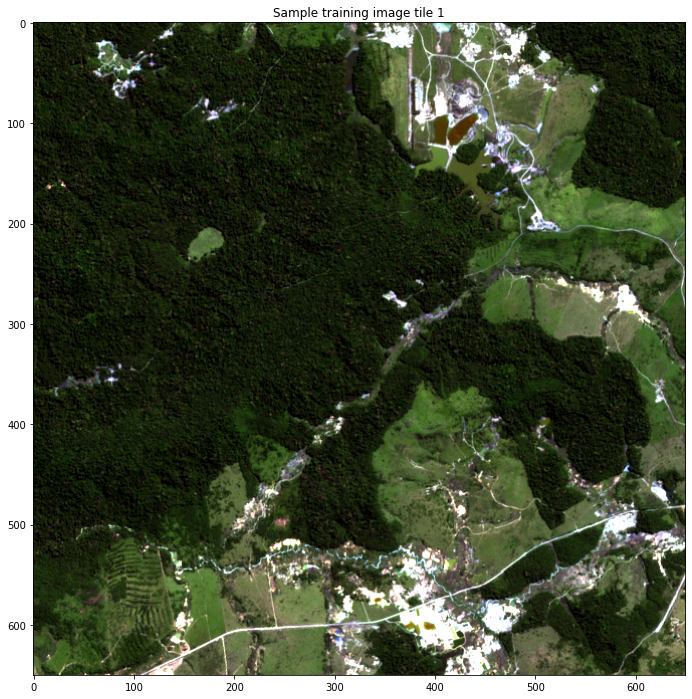

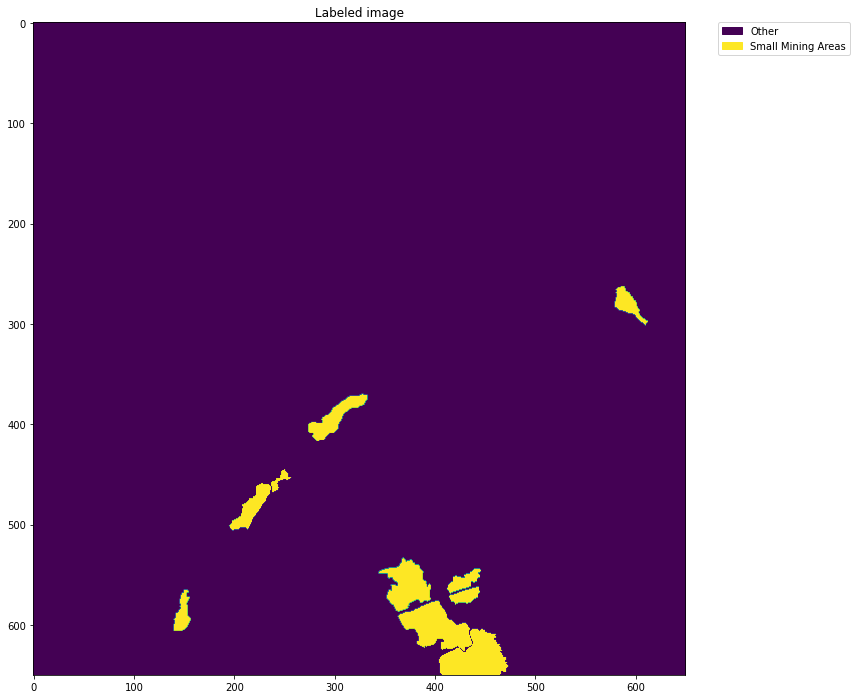

In [ ]:
visualize_data(image_tiles["tile01"], "Sample training image tile 1")
visualize_labels(label_tiles["tile01"])

# Part 2: Sampling the input for FCN model

We then extract samples in the form of image patches (subtiles) from the training image tile in a gridwise manner---systematically splitting the tile into non-overlapping equal-area patches. The image patches' dimensions are defined by the PATCHSIZE hyperparameter. 
The final training data then becomes a four-dimensional array of size NUMBER_SAMPLES  ×  PATCHSIZE  ×  PATCHSIZE  ×  NUMBER_BANDS.

In [ ]:
# Define the patchsize(128) and number of bands (in this case, only 3 bands)

PATCHSIZE = 128
NBANDS = image_tiles["tile01"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)

In [ ]:
# Here, we split the data into training and testing set. Around 75%（20） of the data is used for training, and 25%（7） for testing
import random

overall_tiles = ["tile01", "tile02", "tile03", "tile04", "tile05", "tile06", "tile07", "tile08", "tile09", "tile10", 
                 "tile11", "tile12", "tile13", "tile14", "tile15", "tile16", "tile17", "tile18", "tile19", "tile20", 
                 "tile21", "tile22", "tile23", "tile24", "tile25", "tile26", "tile27"]
random.seed(10)

train_tiles = random.sample(overall_tiles,20)
test_tiles = list(set(overall_tiles)^set(train_tiles))
print(train_tiles)
print(test_tiles)

['tile19', 'tile02', 'tile14', 'tile16', 'tile27', 'tile01', 'tile07', 'tile15', 'tile24', 'tile09', 'tile06', 'tile26', 'tile18', 'tile08', 'tile17', 'tile23', 'tile04', 'tile13', 'tile22', 'tile21']
['tile20', 'tile12', 'tile03', 'tile11', 'tile25', 'tile05', 'tile10']


In [ ]:
# sample each training tile systematically in a gridwise manner
for tile in train_tiles:
    X_toadd = gridwise_sample(image_tiles[tile], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[tile], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)

# encode all non-mining areas as one class
Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 500 number of training patches


In [ ]:
# Check the shape of our training data  
print(Xtrain.shape)

(500, 128, 128, 3)


In [ ]:
# Check the shape of label data
print(Ytrain.shape)

(500, 128, 128, 1)


In [ ]:
# check the percentage of mining and non-mining areas in our training dataset 
percent_non_mine = len(Ytrain[Ytrain==1])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==2]))*100
percent_mine = len(Ytrain[Ytrain==2])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==2]))*100

print("The percentage of mining areas is:",percent_mine)
print("The percentage of non-mining areas is:",percent_non_mine)

The percentage of mining areas is: 1.02794189453125
The percentage of non-mining areas is: 98.97205810546875


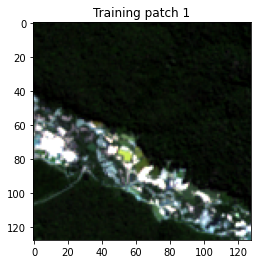

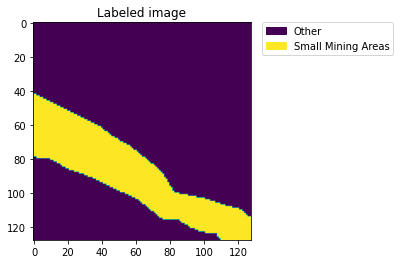

In [ ]:
# Now we visualize one of the training patches and its labeled image

PATCH_NO = 1
visualize_data(Xtrain[PATCH_NO], "Training patch "+str(PATCH_NO), 4, 4)
visualize_labels(Ytrain[PATCH_NO], 4, 4)

# Part 3: Setting-up the network

we proceed on training our classifier in the form of a fully convolutional network. The network receives as an input the set of training patches we prepared in the previous step and produce output predictions of the same spatial dimensions (height and width) of the input. The network has 3 convolutional layers and trained (from random intialization) via stochastic gradient descent for a few number of epochs (since training takes a lot of time!). And we visualize the change in the objective loss function value and classification accuracy over time.

In [ ]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from keras import backend as K
from keras.optimizers import SGD, Adadelta

import tensorflow.python.keras.backend as K
sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))


In [ ]:
NUMBER_BANDS = 3
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 40  #40

In [ ]:
# Before we direclty dive into training, the Y needs to be reformatted 
def to_categorical_4d(y, nc):
    """Convert a reclassed ground truth array to one-hot encoding
    
    Keyword arguments:
    y -- ground truth image
    nc -- number of classes
    """
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0] != 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y

# transform target arrays to one-hot encodings
Ytrain = to_categorical_4d(Ytrain, 2)

## FCN Model
First, let's see how FCN performs on this 

In [ ]:
def build_FCN(optimizer, nrows, ncols, nbands):
    """Function to create Keras model of sample network."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(7, 7),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
              pool_size=(3, 3),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(keras.layers.Conv2D(
              filters=NUMBER_CLASSES,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model


def train(model, data, labels):
    hist = model.fit(x=data,
                     y=labels,
                     epochs=NUMBER_EPOCHS,
                     verbose=2
                    )
    return hist




def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# model definition
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2)
fcn = build_FCN(opt, PATCHSIZE, PATCHSIZE, NUMBER_BANDS)

fcn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m]) #'adam'

# model training
history = train(fcn, Xtrain, Ytrain)

Epoch 1/40
16/16 - 1s - loss: 0.4426 - acc: 0.8648 - f1_m: 0.8671 - precision_m: 0.8671 - recall_m: 0.8671
Epoch 2/40
16/16 - 1s - loss: 0.1967 - acc: 0.9835 - f1_m: 0.9832 - precision_m: 0.9832 - recall_m: 0.9832
Epoch 3/40
16/16 - 1s - loss: 0.1411 - acc: 0.9826 - f1_m: 0.9827 - precision_m: 0.9827 - recall_m: 0.9827
Epoch 4/40
16/16 - 1s - loss: 0.1116 - acc: 0.9845 - f1_m: 0.9834 - precision_m: 0.9834 - recall_m: 0.9834
Epoch 5/40
16/16 - 1s - loss: 0.0988 - acc: 0.9860 - f1_m: 0.9862 - precision_m: 0.9862 - recall_m: 0.9862
Epoch 6/40
16/16 - 1s - loss: 0.0747 - acc: 0.9885 - f1_m: 0.9886 - precision_m: 0.9886 - recall_m: 0.9886
Epoch 7/40
16/16 - 1s - loss: 0.0790 - acc: 0.9867 - f1_m: 0.9870 - precision_m: 0.9870 - recall_m: 0.9870
Epoch 8/40
16/16 - 1s - loss: 0.0645 - acc: 0.9878 - f1_m: 0.9880 - precision_m: 0.9880 - recall_m: 0.9880
Epoch 9/40
16/16 - 1s - loss: 0.0603 - acc: 0.9882 - f1_m: 0.9883 - precision_m: 0.9883 - recall_m: 0.9883
Epoch 10/40
16/16 - 1s - loss: 0.0570

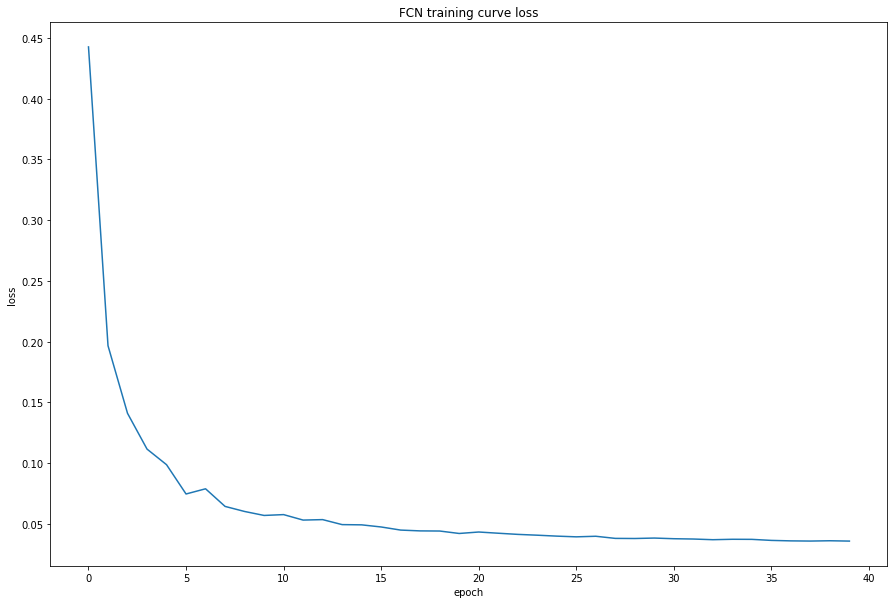

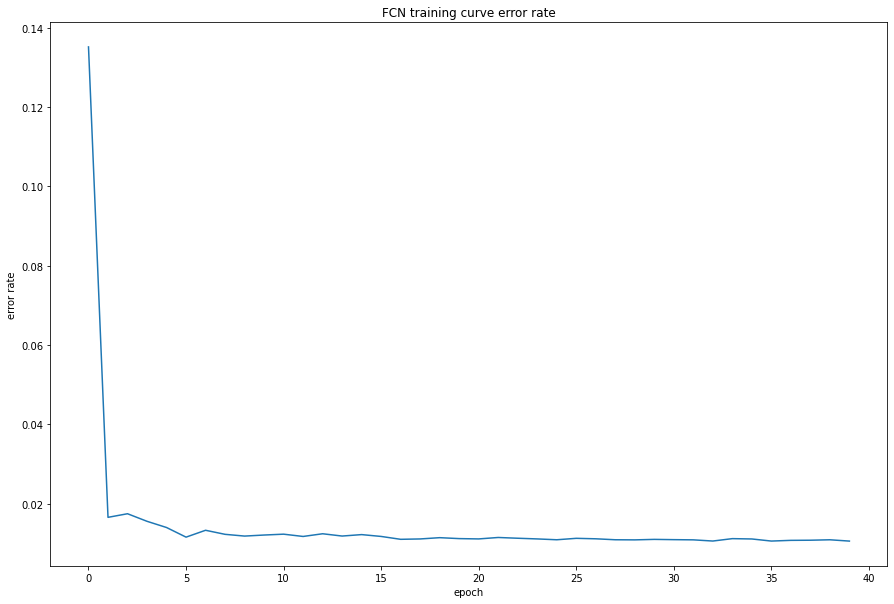

In [ ]:
# plot learning curve of the FCN Model
plt.plot(history.history["loss"])
plt.title("FCN training curve loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.plot(1-np.array(history.history["acc"]))
plt.title("FCN training curve error rate")
plt.ylabel("error rate")
plt.xlabel("epoch")
plt.show()

In [ ]:
print(fcn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 134, 134, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 132, 132, 32)      0

## Evaluate the trained FCN model

After successfully training the network, we now want to assess its classification accuracy on some dataset that has not been used in the training---either to assess the performance of its current configuration (validation set) or to report a final classification accuracy (test set)

In [ ]:
# test the model on tile 25
Xtest = image_tiles["tile25"]
Ytest = label_tiles["tile25"]


In [ ]:
print(Ytest.shape)
print(Ytest)

(650, 650, 1)
[[[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [2]
  [1]
  [1]]

 ...

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]]


In [ ]:
cut = 128
overlap = 96

In [ ]:
def evaluate_predictions(Xtest,cut, overlap, Ytest):
    """
    Function to predict full tiles strip-wise (as loading whole tiles might not fit in the memory).
    """
    Ytest = Ytest.copy()
    Ytest[Ytest!=2] = 0
    Ytest[Ytest==2] = 1
    ncols, nrows, nbands = Xtest.shape
    Xtest = np.expand_dims(Xtest, axis=0)
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%cut==0:
        numstrips = int(nrows/cut)
    else:
        numstrips = int(nrows/cut) + 1
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            if (striptop+height)%(4)!=0:
                height = height*4
            X_sub = Xtest[:, -(striptop+height):, :, :]
            last = True        
        sub_nrows = X_sub.shape[1]
        sub_ncols = X_sub.shape[2]
        model = fcn
        
        sub_ns, sub_nb, _, __ = X_sub.shape
        cmap = model.predict_on_batch([X_sub])
        cmap = np.argmax(cmap[0], axis=2)
        if not last:
            total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            total_map[-(height):, :] = cmap[-(height):, 0:total_map.shape[1]]
    return total_map

predictions_FCN = evaluate_predictions(Xtest, cut, overlap, Ytest)


Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Last hit!
Strip number: 5
Last hit!


In [ ]:
import string
from matplotlib import colors
from sklearn.metrics import f1_score, precision_score, recall_score

# set color codes of the classes
_mines = [120, 61, 14]
_others = [200, 199, 219]
ccolors = (_mines, _others)
NROWS, NCOLS, NBANDS = Xtest.shape

In [ ]:

def print_map(predictions, idxarray, filename=None, title=None, ccolors=None):
    """Print the classified map.

    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
    """
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename,
                                                             NCOLS,
                                                             NROWS,
                                                             NUMBER_CLASSES,
                                                             gdal.GDT_Byte)
        for i in range(NUMBER_CLASSES):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])


def get_confusion_matrix(predictions, labels):
    """Compute the confusion matrix.

    Keyword arguments:
    prediction -- the array output labels from the classification
    results
    labels -- the  array of "true" labels from the test set
    Both arrays should match, be arranged accordingly, and
    have non-negative values.
    """
    classes = np.unique(labels)
    nbclasses = classes.size
    if labels.size != predictions.size:
        raise ValueError("There should be the same number of " +
                         "predictions and labels.")
    merged = np.concatenate((predictions.reshape(predictions.size, 1),
                             labels.reshape(labels.size, 1)), axis=1)
    CM = np.zeros((classes[-1] + 1, classes[-1] + 1))
    for c1 in classes:
        for c2 in classes:
            CM[c1, c2] = np.sum(np.logical_and(merged[:, 1] == c1,
                                               merged[:, 0] == c2))
    return CM


def cartesian(arrays, out=None):
    """Utility function to create cartesian image coordinates."""
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)
    m = int(n / arrays[0].size)
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out


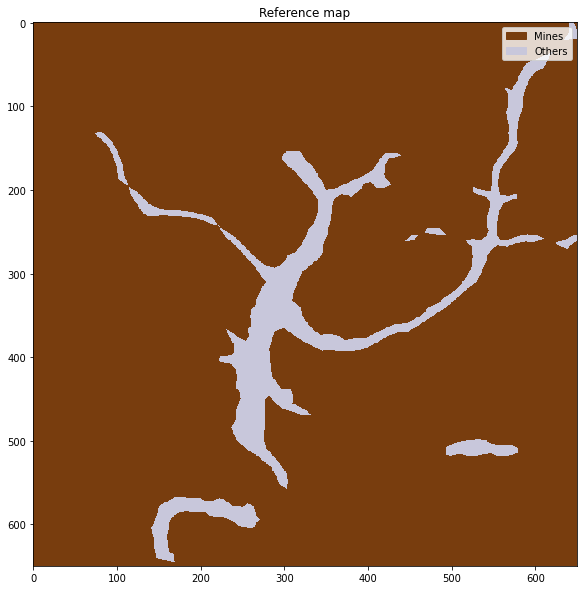

Accuracy metrics of FCN results
Overall Accuracy: 0.929406
F1_score: 0.013052
PA of others: 0.999939
PA of mines: 0.013636


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


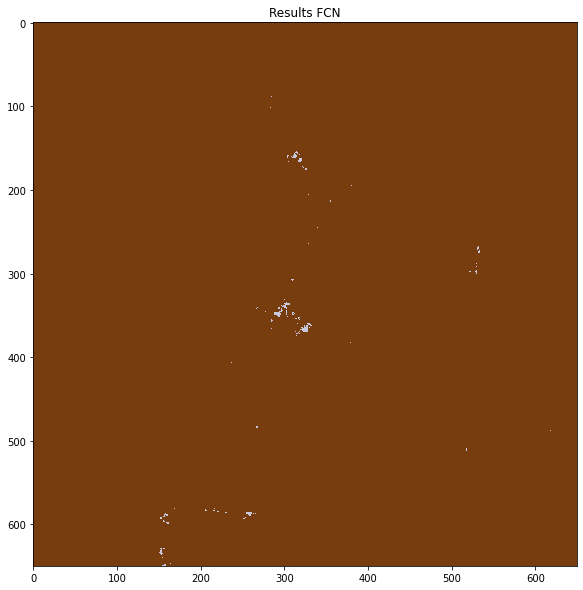

In [ ]:
# plot reference map
norm_ccolors = np.array(ccolors)/255.0
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
cmap = colors.ListedColormap(norm_ccolors)
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = Ytest[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
ax.imshow(labels, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Reference map")
rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["Mines", "Others"]
#Create legend from custom artist/label lists
ax.legend(rectangles, classes)
plt.show()
labels = labels.astype("uint8")

# evaluate FCN
predictions = predictions_FCN
mapidx = cartesian([range(predictions.shape[0]), range(predictions.shape[1])])
CM = get_confusion_matrix(predictions, labels)
OA = np.sum(np.diag(CM))/predictions.size
PA_bldg = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_rd = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)
mapfname = "map_FCN.tif"
print("Accuracy metrics of FCN results")
print("Overall Accuracy: %f" % OA)
print("F1_score: %f" %(f1_score(labels, predictions, average="macro")))
print("PA of others: %f" % PA_bldg)
print("PA of mines: %f" % PA_rd)
predictions_ = predictions.flatten()
print_map(predictions_, mapidx, ccolors=ccolors, filename=mapfname)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(predictions, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Results FCN")
plt.show()     